In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as k
import matplotlib.pyplot as plt


from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from importlib import reload

tf.enable_eager_execution()
print(tf.executing_eagerly())

print(tf.__version__)
print(k.__version__)
print(tf.test.is_gpu_available())

True
1.15.0
2.2.4-tf
True


In [0]:
BATCH_SIZE = 128
LATENT_DIM = 10
SIZE = 28
NUM_CHANNELS = 1
LR = 0.0001
BETA = 1.
GAMMA = 1.

In [0]:
### loading mnist data
(train_images, y_train), (test_images, y_test) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape((-1,28,28,1)).astype('float32')
test_images = test_images.reshape((-1,28,28,1)).astype('float32')
train_images /= 255.
test_images /= 255.

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(1000).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(1000).batch(BATCH_SIZE)

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as k

def make_model(SIZE=28, LATENT_DIM=10, BETA=1., GAMMA=1.):

    def sample(inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        epsilon = tf.random.normal(shape=(batch, LATENT_DIM))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    # Encoder
    encoder_inputs = layers.Input(shape=(SIZE, SIZE, 1), name='encoder_input')
    e = layers.Conv2D(filters=8,kernel_size=5,padding='SAME',activation='relu',strides=(2,2))(encoder_inputs)
    e = layers.BatchNormalization()(e)
    e = layers.Conv2D(filters=16,kernel_size=5,padding='SAME',activation='relu',strides=(2,2))(e)
    e = layers.BatchNormalization()(e)
    e = layers.Flatten()(e)
    z_mean = layers.Dense(LATENT_DIM, name='z_mean')(e)
    z_log_var = layers.Dense(LATENT_DIM, name='z_log_var')(e)
    encoder = k.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var], name='encoder')
    
    
    # Decoder
    decoder_inputs = layers.Input(shape=(LATENT_DIM,), name='decoder_input')
    d = layers.Dense(units=7*7*8,activation='relu')(decoder_inputs)
    d = layers.Reshape((7,7,8))(d)
    d = layers.Conv2DTranspose(filters=16,kernel_size=4,strides=(2, 2), padding="SAME", activation='relu')(d)
    d = layers.Conv2DTranspose(filters=32,kernel_size=4,strides=(2, 2), padding="SAME", activation='relu')(d)
    decoded = layers.Conv2DTranspose(filters=1, kernel_size=3,strides=(1, 1), padding="SAME")(d)
    decoder = k.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')
    
    
    # GAN Discriminator
    discriminator_input = layers.Input(shape=(SIZE, SIZE, 1), name='discriminator_input')
    p = layers.Conv2D(filters=8,kernel_size=5,padding='SAME',activation='relu',strides=(2,2))(discriminator_input)
    p = layers.BatchNormalization()(p)
    p = layers.Conv2D(filters=16,kernel_size=5,padding='SAME',activation='relu',strides=(2,2))(p)
    p = layers.BatchNormalization()(p)
    p = layers.Flatten()(p)
    out = layers.Dense(1, name='discriminator_out')(p)
    discriminator = k.Model(inputs=discriminator_input, outputs=[out,p] , name='discriminator')
    
    
    sampler = layers.Lambda(sample)
    vae = k.Model(inputs=encoder_inputs, outputs=decoder(sampler([z_mean, z_log_var])), name='vae')

    
    def log_normal_pdf(sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)
    
    
    def calculate_loss(x):
        z_p = tf.random.normal(shape=(tf.shape(x)[0],LATENT_DIM))
        z_mean, z_log_var = encoder(x)
        z = sample([z_mean, z_log_var])
        out = decoder(z)
        x_p = decoder(z_p)
        dis_x_p, dis_x_p_feat = discriminator(x_p)
        dis_x, dis_x_feat = discriminator(x)
        dis_x_tilde , dis_x_tilde_feat = discriminator(out)

        # kl loss
        logpz = log_normal_pdf(z, 0., 0.)
        logqz_x = log_normal_pdf(z, z_mean, z_log_var)
        kl_loss = tf.reduce_mean(logqz_x - logpz)

        
        # gaussian perceptual loss as reconstruction loss
        reconstruction_loss = -tf.reduce_mean(log_normal_pdf(dis_x_feat, dis_x_tilde_feat, tf.zeros_like(dis_x_tilde_feat)))
        

        # gan loss
        cross_entropy = k.losses.BinaryCrossentropy(from_logits=True)
        g_fake = cross_entropy(tf.ones_like(dis_x_tilde), dis_x_tilde)
        g_fake_p = cross_entropy(tf.ones_like(dis_x_p), dis_x_p)
        d_real = cross_entropy(tf.ones_like(dis_x), dis_x)
        d_fake = cross_entropy(tf.zeros_like(dis_x_tilde), dis_x_tilde)
        d_fake_p = cross_entropy(tf.zeros_like(dis_x_p), dis_x_p)

        return BETA*kl_loss , GAMMA*reconstruction_loss , g_fake + g_fake_p, d_fake + d_fake_p + d_real
        
    
    def feed(x, encoder, decoder, discriminator, optimizer):
    
        with tf.GradientTape(persistent=True) as tape:
            l_kl, l_rec, l_gen, l_dis = calculate_loss(x)
            l_enc = l_kl + l_rec
            l_dec = l_rec + l_gen

        enc_grads = tape.gradient(l_enc, encoder.trainable_variables)
        optimizer.apply_gradients(zip(enc_grads, encoder.trainable_variables))

        dec_grads = tape.gradient(l_dec, decoder.trainable_variables)
        optimizer.apply_gradients(zip(dec_grads, decoder.trainable_variables))

        dis_grads = tape.gradient(l_dis, discriminator.trainable_variables)
        optimizer.apply_gradients(zip(dis_grads, discriminator.trainable_variables))

        return l_kl.numpy(), l_rec.numpy(), l_gen.numpy(), l_dis.numpy()


    def train(x, encoder, decoder, discriminator, optimizer):
        l_kl, l_rec, l_gen, l_dis = 0., 0., 0., 0.
        n = 0
        for train_x in x:
            a, b, c, d = feed(train_x, encoder, decoder, discriminator, optimizer)
            l_kl += a
            l_rec += b
            l_gen += c
            l_dis += d
            n += 1
        
        return l_kl / n, l_rec / n, l_gen / n, l_dis / n
    
    
    return encoder, decoder, discriminator, vae, train

In [14]:
encoder, decoder, discriminator, vae, train = make_model()
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 14, 14, 8)    208         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 14, 14, 8)    32          conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 7, 7, 16)     3216        batch_normalization_12[0][0]     
________________________________________________________________________________________________

In [15]:
for epoch in tqdm(range(30)):
    l = train(train_dataset, encoder, decoder, discriminator, k.optimizers.Adam(1e-4))
    if (epoch+1) % 1 == 0:
        print('\n'+'kl_loss:', l[0], 'rec_loss:', l[1], 'gen_loss:', l[2], 'dis_loss:', l[3])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

kl_loss: 1.941536788000608 rec_loss: 740.3961408082356 gen_loss: 3.038135583975168 dis_loss: 1.1250893266470448

kl_loss: 9.791395844172822 rec_loss: 752.8531112833572 gen_loss: 4.487596783810841 dis_loss: 0.8216201157521591

kl_loss: 14.019779939387144 rec_loss: 752.2536930824393 gen_loss: 4.872245823142371 dis_loss: 0.6645931222482022

kl_loss: 15.583490422539619 rec_loss: 754.5771421908315 gen_loss: 4.8520169568214335 dis_loss: 0.7160409792526953

kl_loss: 16.81325439095243 rec_loss: 758.4587704266058 gen_loss: 5.085830196388749 dis_loss: 0.5895227214802049

kl_loss: 17.82356340290387 rec_loss: 761.6056086493453 gen_loss: 5.4152079157229425 dis_loss: 0.5396142964805367

kl_loss: 18.669510375716285 rec_loss: 764.4692087397138 gen_loss: 5.713173344699559 dis_loss: 0.5081798382151101

kl_loss: 19.438035017391766 rec_loss: 767.4278866375433 gen_loss: 5.857325664715472 dis_loss: 0.4906106842225

(128, 28, 28, 1)


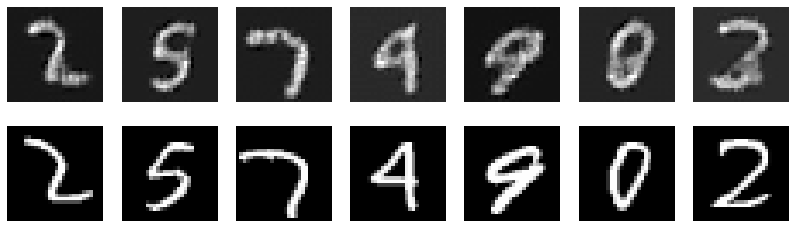

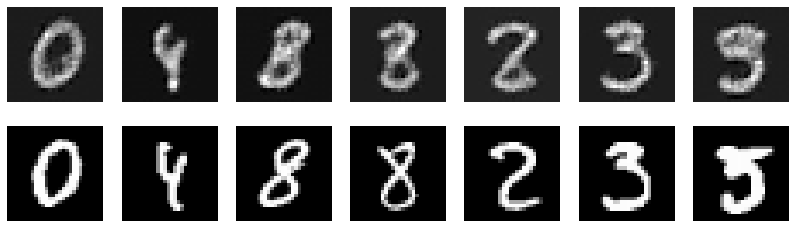

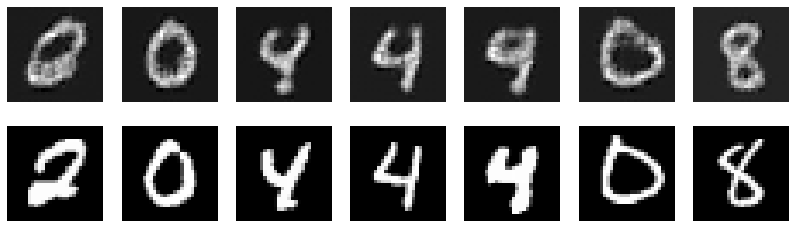

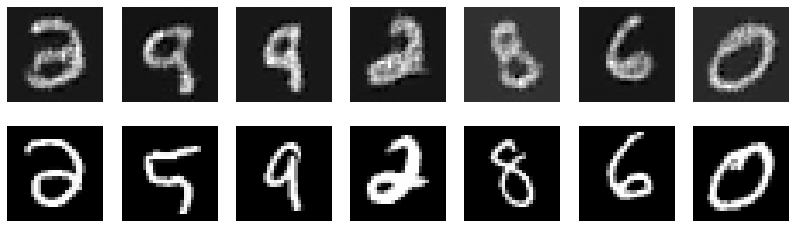

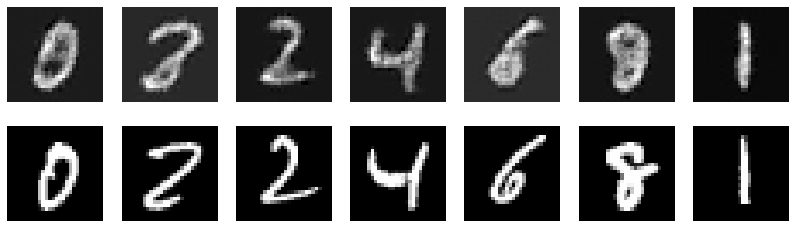

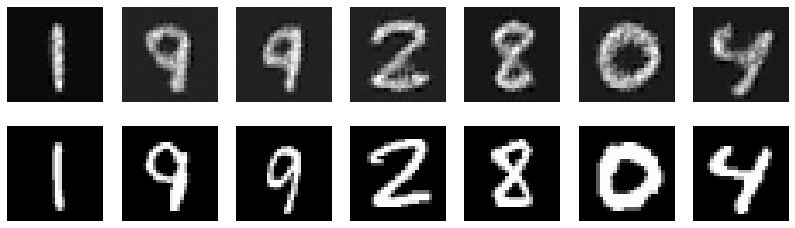

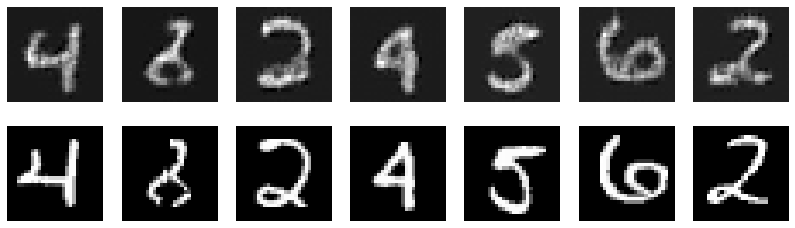

In [18]:
m, n = 7,7
iter_ = test_dataset.make_one_shot_iterator()
x = iter_.get_next()
reconstructions = vae.predict(x,steps=1)
print(reconstructions.shape)
for i in range(m):
    plt.figure(figsize=(14, 4))
    for j in range(n):
        plt.subplot(2, n,j +1)
        plt.imshow(reconstructions[i*n + j, :, :, 0], cmap='gray')
        plt.axis('off')

        plt.subplot(2, n,1 + j + n)
        plt.imshow(x[i*n + j, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

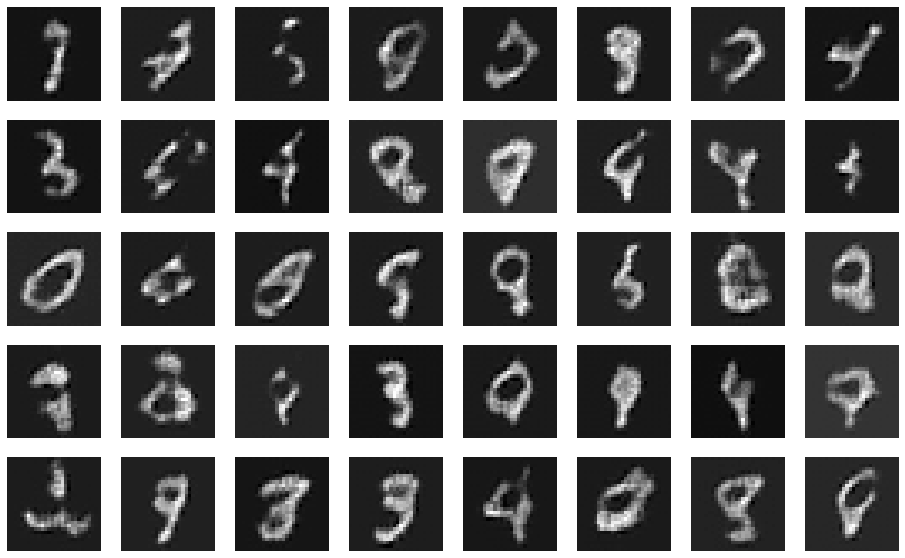

In [19]:
m, n = 5,8
preds = decoder.predict(np.random.normal(size=(m*n,LATENT_DIM)))
plt.figure(figsize=(n*2, m*2))
for i in range(m*n):
    plt.subplot(m, n,i +1)
    plt.imshow(preds[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()